<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/Elliot%20M/IntegratedGradientsImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TO DO THIS, GO ON KAGGLE :https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

THEN DOWLOAD TO ZIP USINNG THE DOWLOAD BUTTON.

THEN ADD IT TO YOUR GOOGLE DRIVE AS A ZIP FILE.
THEN MYDIRVE/YOUR_NOTEBOOK/DATASET.ZIP


In [2]:
!unzip "/content/drive/MyDrive/DST/archive.zip" -d "/content/data"



Archive:  /content/drive/MyDrive/DST/archive.zip
  inflating: /content/data/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(20).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(21

In [3]:
!ls /content/data


Testing  Training


Loaded image: /content/data/Training/glioma_tumor/gg (217).jpg


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

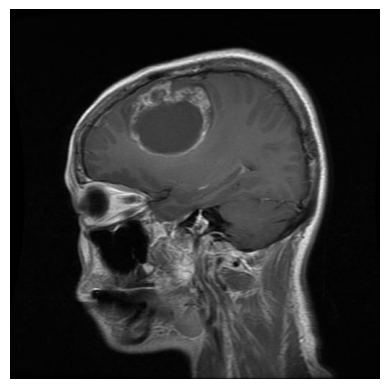

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

root = "/content/data/Training"

# Find the first image in the training folder
image_path = None
for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(subdir, file)
            break
    if image_path:
        break

print("Loaded image:", image_path)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")


## Simple CNN Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        # 224 → 112 → 56 after pooling twice
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))   # (32, 56, 56)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Multi-Layer Perceptron:

Here, we also build a simple multi-layer perceptron which will likely perform badly, and using our interpretation method heatmaps, we can show that the MLP does not encapture the 2D structure of the input (image) and therefore performs much worse.

In [6]:
class BrainTumourMLP(nn.Module):
    def __init__(self, input_dim=3*224*224, hidden1=512, hidden2=256, num_classes=4):
        super().__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.model(x)


## Dataloaders

These will stay the same for the CNN and MLP as the MLP flattens the image as the first step using nn.Flatten().

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

train_dataset = datasets.ImageFolder("/content/data/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


## CNN Training block

In [8]:
import torch.optim as optim
import os, time, json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_acc = 0
checkpoint_path = "best_smallcnn.pth"

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

EPOCHS = 10   # fast training

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total


    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(test_loader)
    val_acc = val_correct / val_total

    # Track
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    # Save based on accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved best model → {checkpoint_path}")


Epoch [1/10] | Train Acc: 0.613 | Val Acc: 0.401
Saved best model → best_smallcnn.pth
Epoch [2/10] | Train Acc: 0.861 | Val Acc: 0.660
Saved best model → best_smallcnn.pth
Epoch [3/10] | Train Acc: 0.949 | Val Acc: 0.723
Saved best model → best_smallcnn.pth
Epoch [4/10] | Train Acc: 0.980 | Val Acc: 0.706
Epoch [5/10] | Train Acc: 0.992 | Val Acc: 0.708
Epoch [6/10] | Train Acc: 0.995 | Val Acc: 0.718
Epoch [7/10] | Train Acc: 0.999 | Val Acc: 0.746
Saved best model → best_smallcnn.pth
Epoch [8/10] | Train Acc: 1.000 | Val Acc: 0.766
Saved best model → best_smallcnn.pth
Epoch [9/10] | Train Acc: 1.000 | Val Acc: 0.739
Epoch [10/10] | Train Acc: 1.000 | Val Acc: 0.741


In [9]:
model = SmallCNN(num_classes=4)
model.load_state_dict(torch.load("best_smallcnn.pth"))
model.to(device)
model.eval()


SmallCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

## MLP Training Block

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = BrainTumourMLP(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

def compute_accuracy(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

for epoch in range(10):
    mlp.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mlp(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_acc = compute_accuracy(mlp, train_loader, device)
    test_acc = compute_accuracy(mlp, test_loader, device)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Loss: {running_loss/len(train_loader):.4f} | "
        f"Train Acc: {train_acc*100:.2f}% | "
        f"Test Acc: {test_acc*100:.2f}%"
    )


Epoch 01 | Loss: 11.3407 | Train Acc: 49.86% | Test Acc: 32.99%
Epoch 02 | Loss: 1.2710 | Train Acc: 57.07% | Test Acc: 33.50%
Epoch 03 | Loss: 1.2691 | Train Acc: 59.06% | Test Acc: 40.36%
Epoch 04 | Loss: 1.2184 | Train Acc: 62.09% | Test Acc: 39.85%
Epoch 05 | Loss: 1.1200 | Train Acc: 61.32% | Test Acc: 40.86%
Epoch 06 | Loss: 1.1046 | Train Acc: 60.70% | Test Acc: 44.42%
Epoch 07 | Loss: 1.1074 | Train Acc: 47.70% | Test Acc: 40.86%
Epoch 08 | Loss: 1.1381 | Train Acc: 61.85% | Test Acc: 44.42%
Epoch 09 | Loss: 1.0595 | Train Acc: 65.19% | Test Acc: 41.12%
Epoch 10 | Loss: 1.0473 | Train Acc: 64.22% | Test Acc: 48.22%


In [12]:
mlp.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = mlp(images)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"MLP Test Accuracy: {correct/total:.4f}")


MLP Test Accuracy: 0.4822


As we would expect, the MLP gets a low test accuracy. Now we will implement our interpretation methods and show that the CNN highlights meaning regions (tumour outlines) and the MLP does not.

## Integrated Gradients Implementation

In [13]:

def integrated_gradients(model, x, baseline=None, m_steps=50):
    """
    Compute Integrated Gradients for an input x.
    model: pytorch model
    x: input image tensor of shape (1, C, H, W)
    baseline: same shape as x
    m_steps: number of steps in the Riemann approximation
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    # interpolate between baseline and x
    alphas = torch.linspace(0, 1, m_steps).reshape(-1, 1, 1, 1).to(x.device)
    interpolated = baseline + alphas * (x - baseline)

    # store gradients
    gradients = []

    for i in range(m_steps):
        interpolated_i = interpolated[i].unsqueeze(0).requires_grad_(True)
        output = model(interpolated_i)
        target = output.max(1)[0]  # predicted class score

        model.zero_grad()
        target.backward()

        gradients.append(interpolated_i.grad.detach())

    # approximate integral
    avg_gradients = torch.mean(torch.stack(gradients), dim=0)

    # IG formula
    ig = (x - baseline) * avg_gradients
    return ig


## SG-IG Implementation

In [14]:

def smooth_integrated_gradients(
    model, x, baseline=None, m_steps=50, n_samples=25, noise_sigma=0.1
):
    """
    Compute Smooth Integrated Gradients.
    Averaging IG over noise-perturbed copies of input x.
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    all_igs = []

    for _ in range(n_samples):
        noise = torch.normal(mean=0, std=noise_sigma, size=x.shape).to(x.device)
        x_noisy = x + noise
        ig = integrated_gradients(model, x_noisy, baseline, m_steps)
        all_igs.append(ig)

    return torch.mean(torch.stack(all_igs), dim=0)


## Heatmap plots

Let's get some explainer images and then apply the two interpretation methods, for both the CNN and MLP. First we need to denormalize the explainer images in order to get meaningful plots. Then we can plot heatmaps for each image.

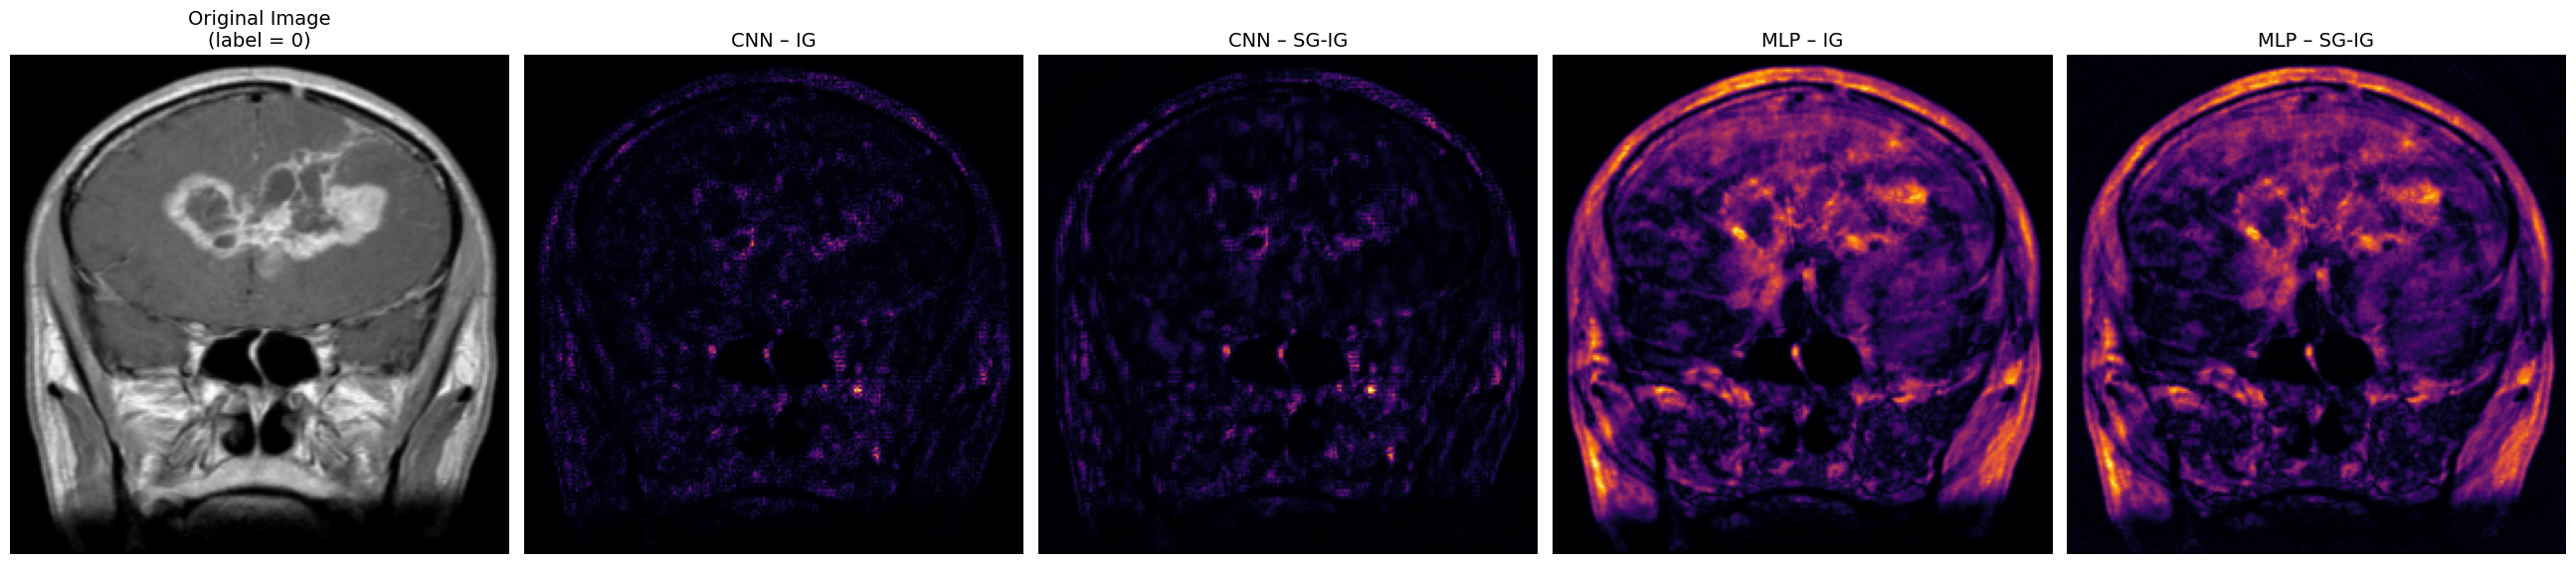

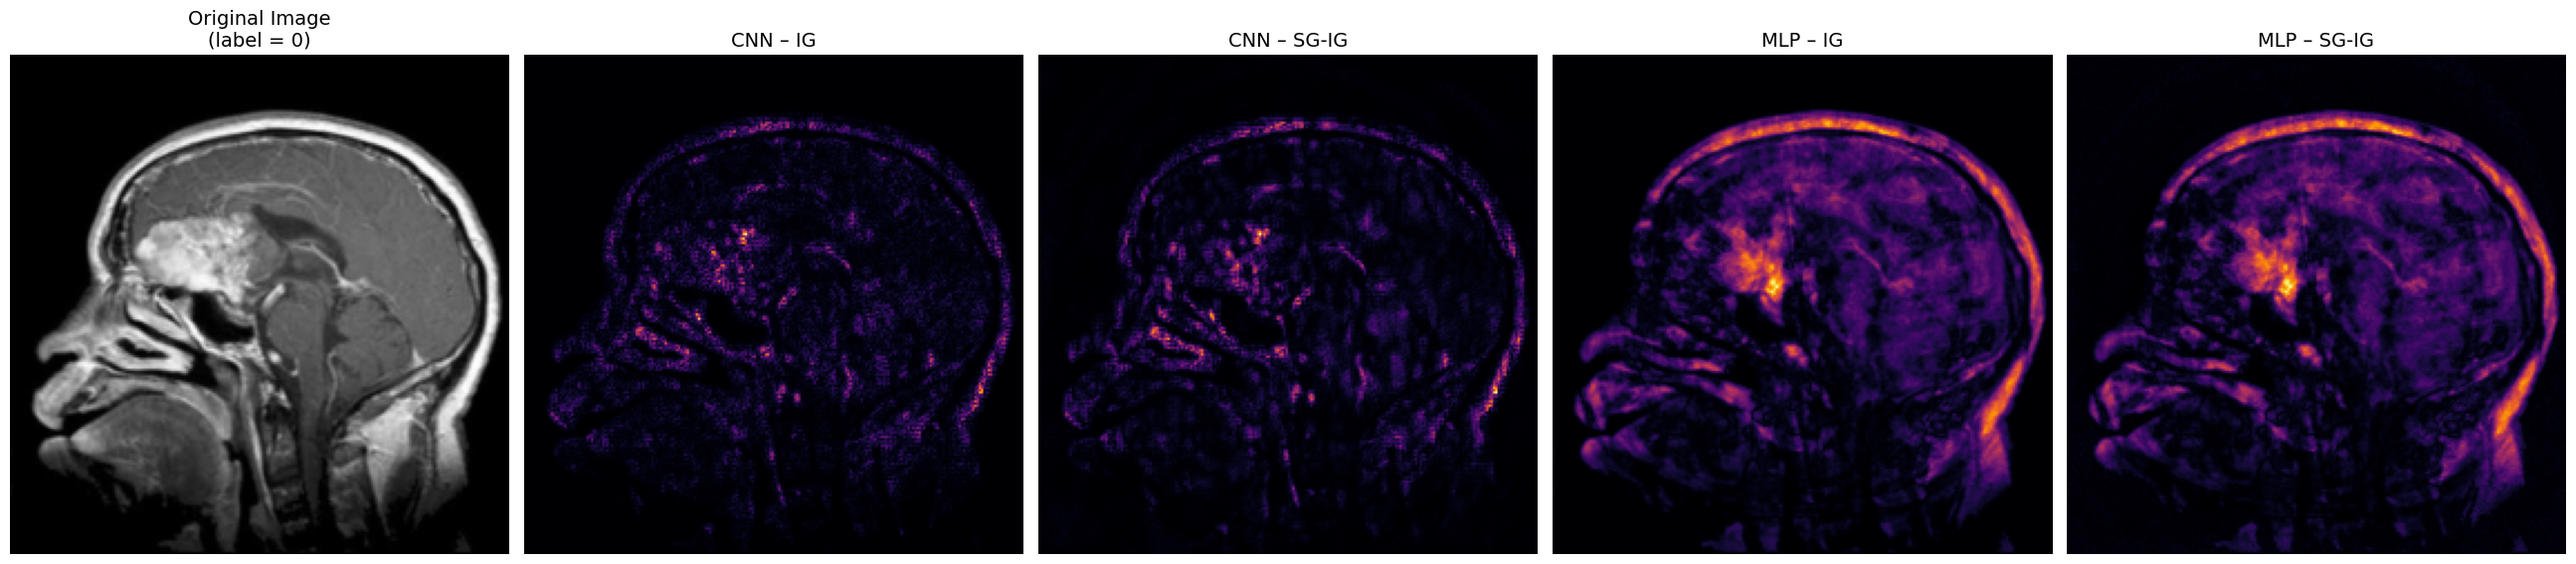

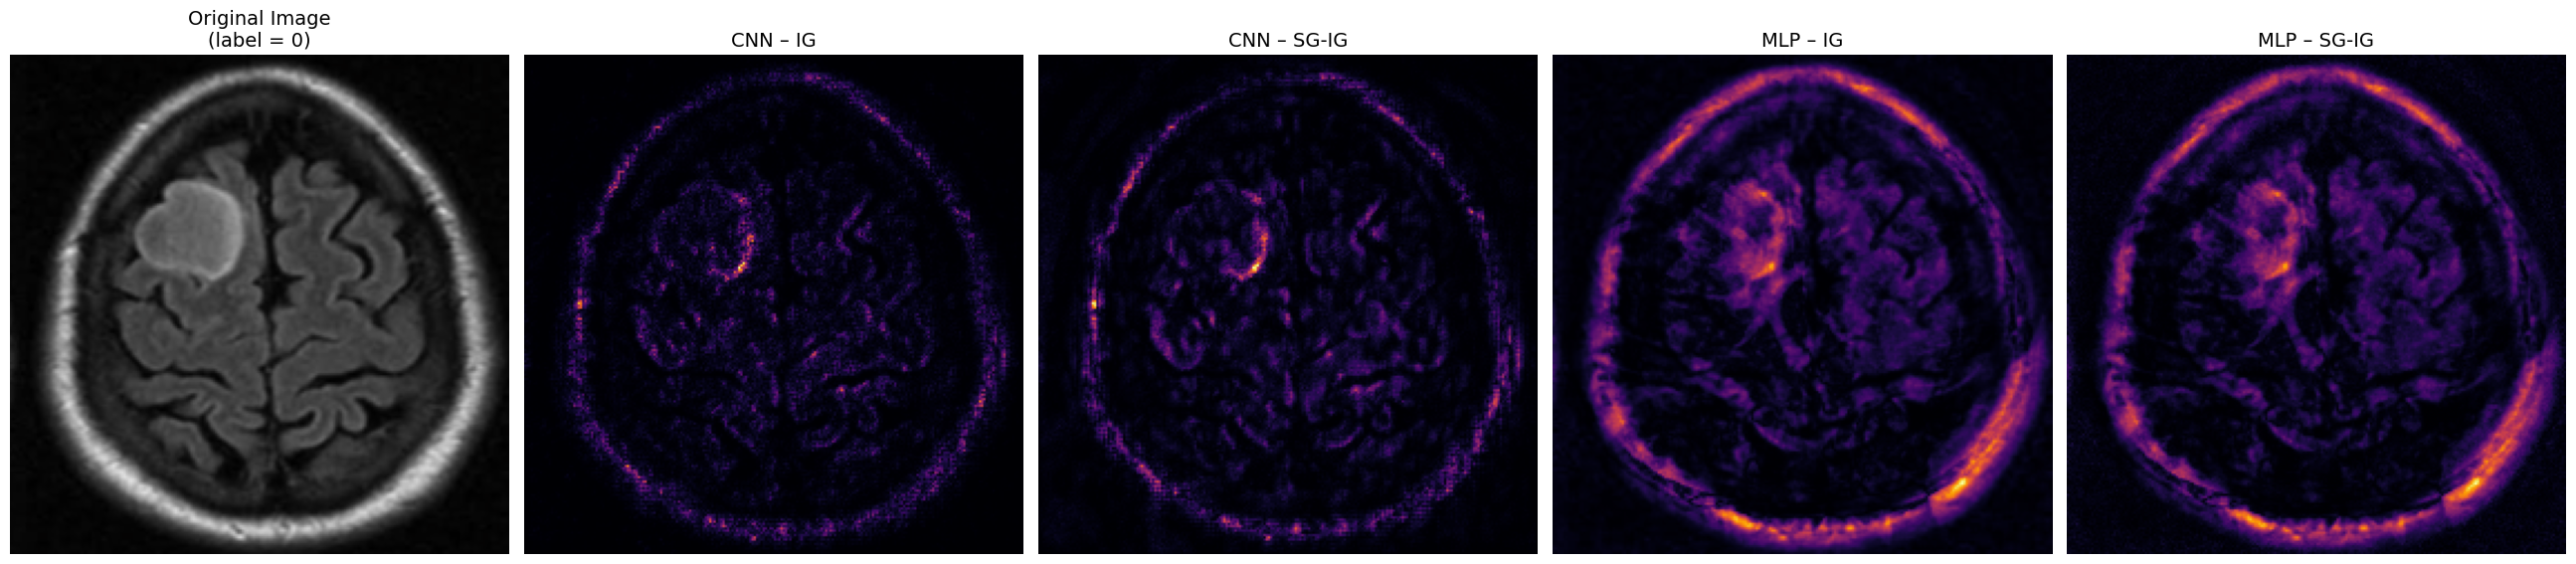

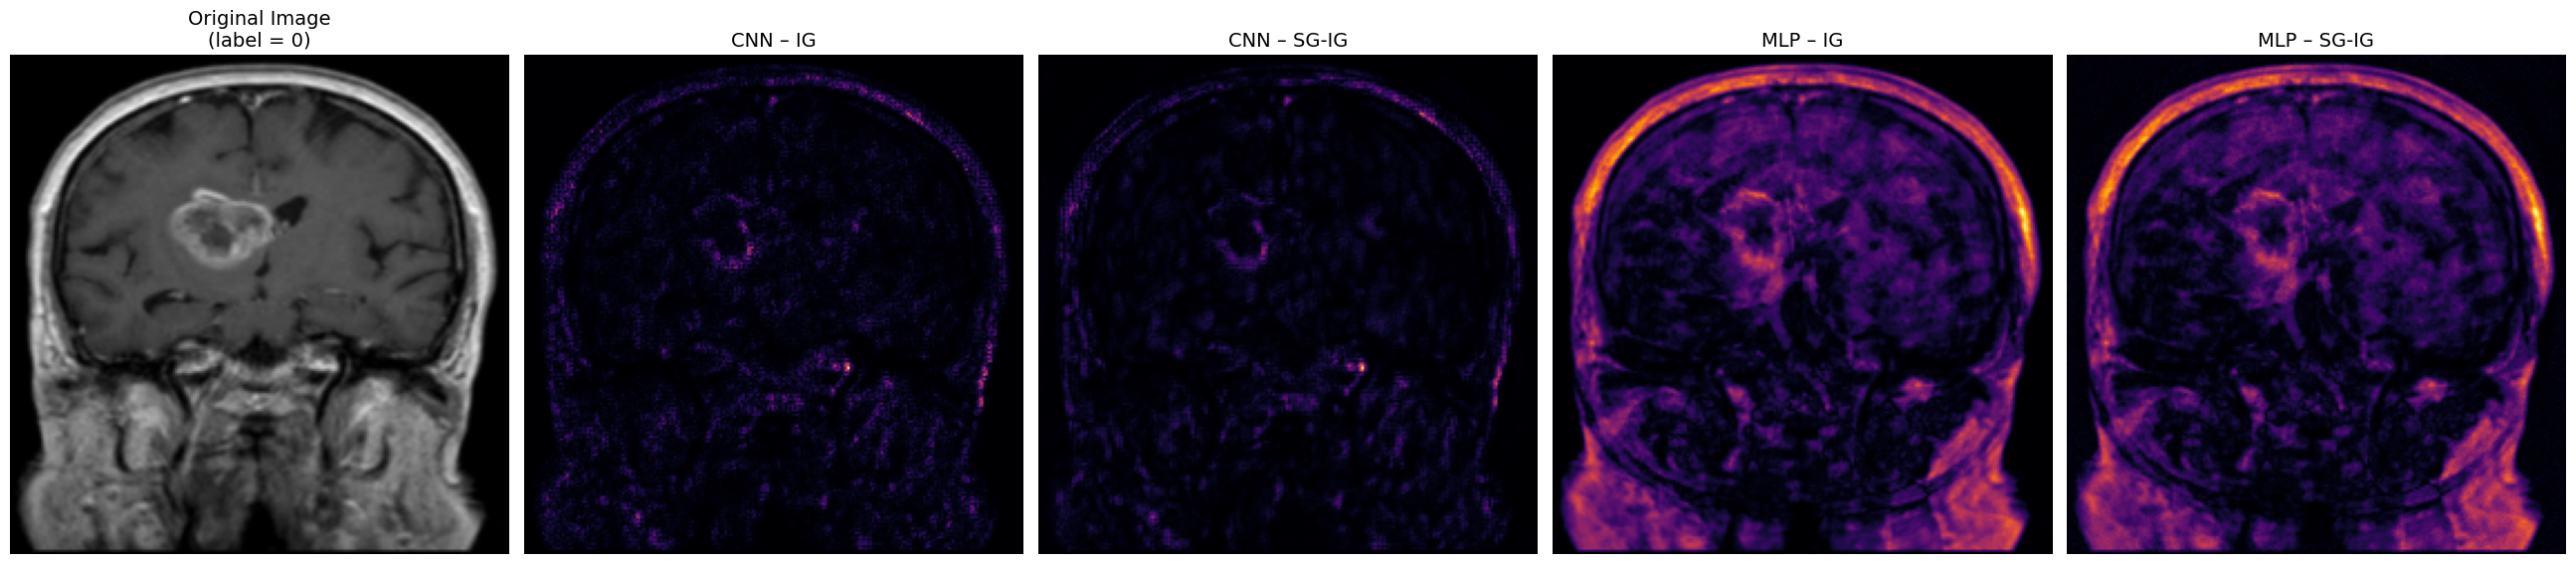

In [37]:
explainer_images, explainer_labels = next(iter(test_loader))

batch_size = explainer_images.shape[0]

# batch size is 32 so I am going to do the first 4
for i in range(batch_size//8):

    explainer_image = explainer_images[i]
    explainer_label = explainer_labels[i].item()

    explainer_image_device = explainer_image.unsqueeze(0).to(device)

    def denormalize(x, mean, std):
        mean = torch.tensor(mean).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor(std).view(1, 3, 1, 1).to(x.device)
        return x * std + mean


    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    explainer_image_denorm = denormalize(explainer_image_device, mean, std)
    baseline = torch.zeros_like(explainer_image_denorm)

    # CNN
    cnn_ig = integrated_gradients(
        model=model,
        x=explainer_image_denorm,
        baseline=baseline,
        m_steps=50
    )

    cnn_sg_ig = smooth_integrated_gradients(
        model=model,
        x=explainer_image_denorm,
        baseline=baseline,
        m_steps=50,
        n_samples=20,
        noise_sigma=0.1
    )

    # MLP

    mlp_ig = integrated_gradients(
        model=mlp,
        x=explainer_image_denorm,
        baseline=baseline,
        m_steps=50
    )

    mlp_sg_ig = smooth_integrated_gradients(
        model=mlp,
        x=explainer_image_denorm,
        baseline=baseline,
        m_steps=50,
        n_samples=20,
        noise_sigma=0.1
    )



    def to_heatmap(attr):
        # attr: shape (1, 3, H, W)
        attr = attr.squeeze(0).detach().cpu().numpy()   # (3, H, W)
        return np.abs(attr).mean(axis=0)                # (H, W)

    def to_numpy_image(t):
        """Convert (1,3,H,W) or (3,H,W) tensor to (H,W,3) NumPy for plotting."""
        t = t.detach().cpu()
        if t.ndim == 4:  # (1,C,H,W)
            t = t.squeeze(0)
        t = t.permute(1, 2, 0)   # C,H,W → H,W,C
        return t.numpy()

    # ORIGINAL IMAGE (DENORMALIZED)

    orig_np = to_numpy_image(explainer_image_denorm)
    orig_np = np.clip(orig_np, 0, 1)   # ensure valid RGB range


    # HEATMAPS

    heatmaps = [
        ("CNN – IG", to_heatmap(cnn_ig)),
        ("CNN – SG-IG", to_heatmap(cnn_sg_ig)),
        ("MLP – IG", to_heatmap(mlp_ig)),
        ("MLP – SG-IG", to_heatmap(mlp_sg_ig)),
    ]

    # PLOT ALL TOGETHER
    fig, axes = plt.subplots(1, 1 + len(heatmaps), figsize=(26, 6))

    # Original Image
    axes[0].imshow(orig_np)
    axes[0].set_title(f"Original Image\n(label = {explainer_label})", fontsize=14)
    axes[0].axis("off")

    # Heatmaps
    for ax, (title, hm) in zip(axes[1:], heatmaps):
        ax.imshow(hm, cmap="inferno")
        ax.set_title(title, fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()



These are interesting results. For some of the plots, suprisingly, the MLP seems to highlight the tumour much more accurately and strongly than the CNN. However, on some of the other plots, as we would expect, the MLP just seems to highlight everything, and not the tumour any more than anything else. The CNN for some plots does seem to hone in much more on the tumour, and doesn't highlight other irrelevant parts like the skull as much. The CNN we fitted was a simpler version of the full model, so in the report section we will hopefully find that our final model produces more accurate heatmaps around the tumour. Nonetheless, it is clear to see these interpretation methods are working for our models / data.